# Compactness analysis


### - Which algorithm store the policy more compactly ?

---

> The goal is to create a df with statistics for all the experiments we saved in the 'baselines/logs' folder. 

In [146]:
import os
import pandas as pd
import glob
import numpy as np

import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO, TD3, SAC

In [147]:
def find_all_models(log_dir= "./baselines/logs", algorithms = {"ppo": "PPO", "dqn": "DQN", "td3": "TD3", "sac": "SAC"}):
    """Find all model files in the logs directory structure more efficiently."""
    
    models = []
    
    # Use os.walk with topdown=True for better performance
    for root, _, files in os.walk(log_dir, topdown=True):
        zip_files = [f for f in files if f == "best_model.zip" or f.endswith(".zip")]
        
        if not zip_files:
            continue
            
    
        path_parts = root.split(os.path.sep)
        
        algorithm = None
        environment = "unknown"
        
        for part_idx, part in enumerate(path_parts):
            if part.lower() in algorithms:
                algorithm = algorithms[part.lower()]
                # Get environment name 
                if part_idx + 1 < len(path_parts):
                    environment = path_parts[part_idx + 1]
                break
        
        if algorithm:
            for zip_file in zip_files:
                model_path = os.path.join(root, zip_file)
                models.append({
                    "path": model_path,
                    "algorithm": algorithm,
                    "environment": environment,
                    "directory": root,
                    'best_model': True if zip_file == "best_model.zip" else False       
                })
    
    return models

In [ ]:
def get_stats(models):
    """Get statistics for each model."""
    
    stats = []
    
    for model in models:
        try:
            # Load the model
            if model["algorithm"] == "PPO":
                loaded_model = PPO.load(model["path"])
            elif model["algorithm"] == "DQN":
                loaded_model = DQN.load(model["path"])
            elif model["algorithm"] == "TD3":
                loaded_model = TD3.load(model["path"])
            elif model["algorithm"] == "SAC":
                loaded_model = SAC.load(model["path"])
            else:
                continue
            
            # Policy compactness
            policy = loaded_model.policy

            num_params = sum(p.numel() for p in policy.parameters())
            num_layers = len(list(policy.parameters()))
            model_size_kb = os.path.getsize(model["path"]) / 1024
            num_zero_params = sum((p == 0).sum().item() for p in policy.parameters())
            sparsity = num_zero_params / num_params if num_params > 0 else 0


            stats.append({
                "algorithm": model["algorithm"],
                "environment": model["environment"],
                "best_model": model['best_model'],
                
                # Size and parameter metrics
                "model_size_kb": model_size_kb,
                "num_params": num_params,
                "num_layers": num_layers,
                "num_zero_params": num_zero_params,
                "sparsity": sparsity,
                
              
            })
        
        except Exception as e:
            print(f"Error loading model {model['path']}: {e}")
  
    return pd.DataFrame(stats)                 

In [149]:
models = find_all_models(log_dir="./baselines/logs")     
print(models)
stats = get_stats(models)   

stats

[{'path': './baselines/logs/sac/MountainCarContinuous/_sac_MountainCarContinuous.zip', 'algorithm': 'SAC', 'environment': 'MountainCarContinuous', 'directory': './baselines/logs/sac/MountainCarContinuous', 'best_model': False}, {'path': './baselines/logs/sac/MountainCarContinuous/best_model.zip', 'algorithm': 'SAC', 'environment': 'MountainCarContinuous', 'directory': './baselines/logs/sac/MountainCarContinuous', 'best_model': True}, {'path': './baselines/logs/sac/Pendulum/_sac_Pendulum.zip', 'algorithm': 'SAC', 'environment': 'Pendulum', 'directory': './baselines/logs/sac/Pendulum', 'best_model': False}, {'path': './baselines/logs/sac/Pendulum/best_model.zip', 'algorithm': 'SAC', 'environment': 'Pendulum', 'directory': './baselines/logs/sac/Pendulum', 'best_model': True}, {'path': './baselines/logs/dqn/MountainCar-v0/best_model.zip', 'algorithm': 'DQN', 'environment': 'MountainCar-v0', 'directory': './baselines/logs/dqn/MountainCar-v0', 'best_model': True}, {'path': './baselines/logs/

/Users/elia/anaconda3/envs/ada/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(
/Users/elia/anaconda3/envs/ada/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(
/Users/elia/anaconda3/envs/ada/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(


,algorithm,environment,best_model,model_size_kb,num_params,num_layers,num_zero_params,sparsity
0,SAC,MountainCarContinuous,False,2925.764648,335366,32,0,0.000000
1,SAC,MountainCarContinuous,True,2924.766602,335366,32,0,0.000000
2,SAC,Pendulum,False,2940.425781,336646,32,0,0.000000
3,SAC,Pendulum,True,2939.413086,336646,32,0,0.000000
4,DQN,MountainCar-v0,True,95.061523,9094,12,0,0.000000
5,DQN,Acrobot-v1,False,99.198242,9606,12,0,0.000000
6,DQN,Acrobot-v1,True,98.724609,9606,12,0,0.000000
7,DQN,CartPole-v0,True,99.131836,9220,12,0,0.000000
8,DQN,CartPole-v0,False,99.114258,9220,12,0,0.000000
9,PPO,MountainCarContinuous,False,136.016602,8835,13,0,0.000000


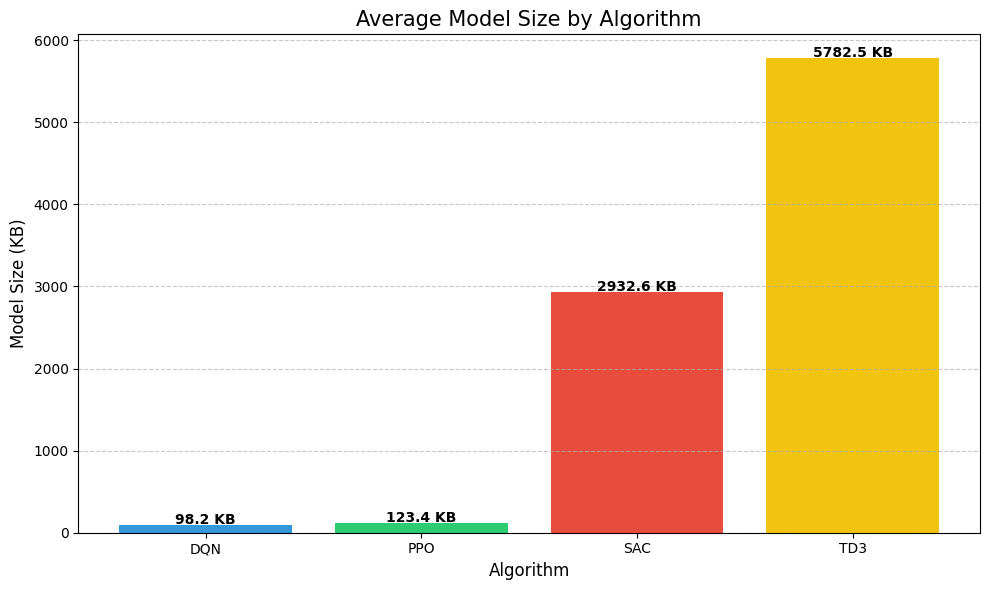

In [145]:
size_by_algo = stats.groupby('algorithm')['model_size_kb'].mean().sort_values()

plt.figure(figsize=(10, 6))
bars = plt.bar(size_by_algo.index, size_by_algo.values, color=['#3498db', '#2ecc71', '#e74c3c', '#f1c40f'])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 10,
             f'{height:.1f} KB', ha='center', fontsize=10, fontweight='bold')


plt.title('Average Model Size by Algorithm', fontsize=15)
plt.ylabel('Model Size (KB)', fontsize=12)
plt.xlabel('Algorithm', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()